Epoch 0, Loss: 9.690790176391602


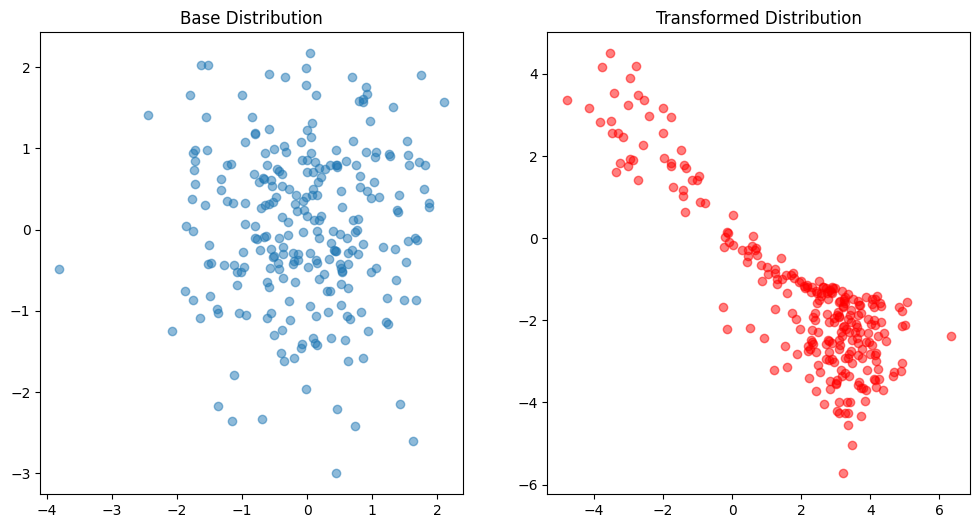

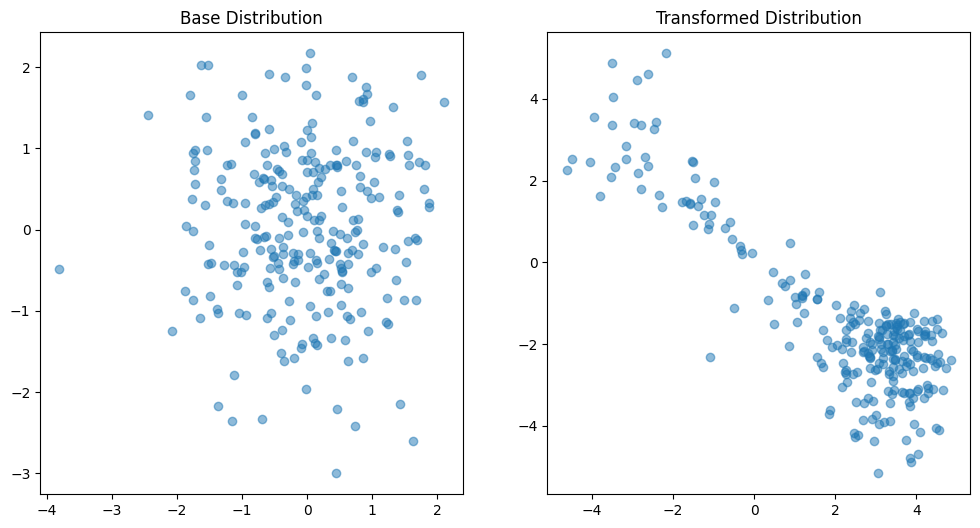

Epoch 250, Loss: 5.10887336730957


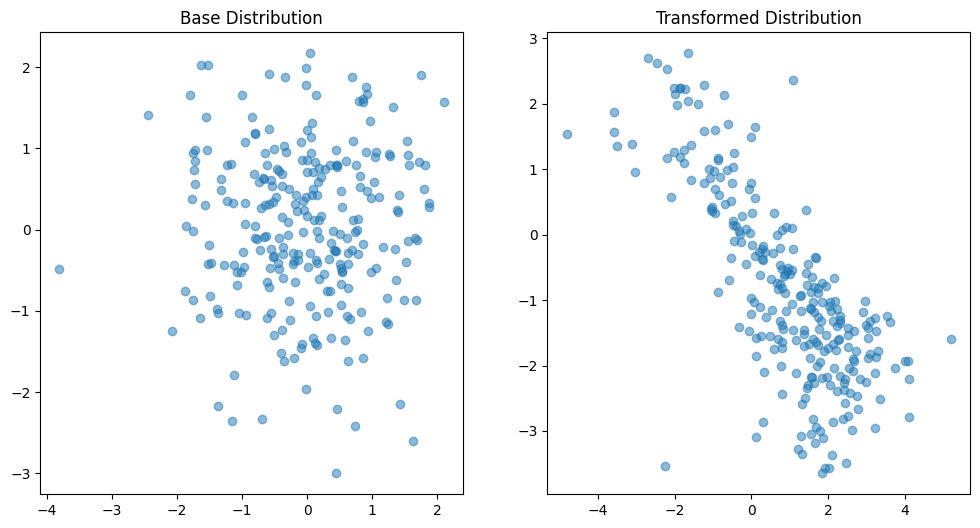

Epoch 500, Loss: 3.0462825298309326


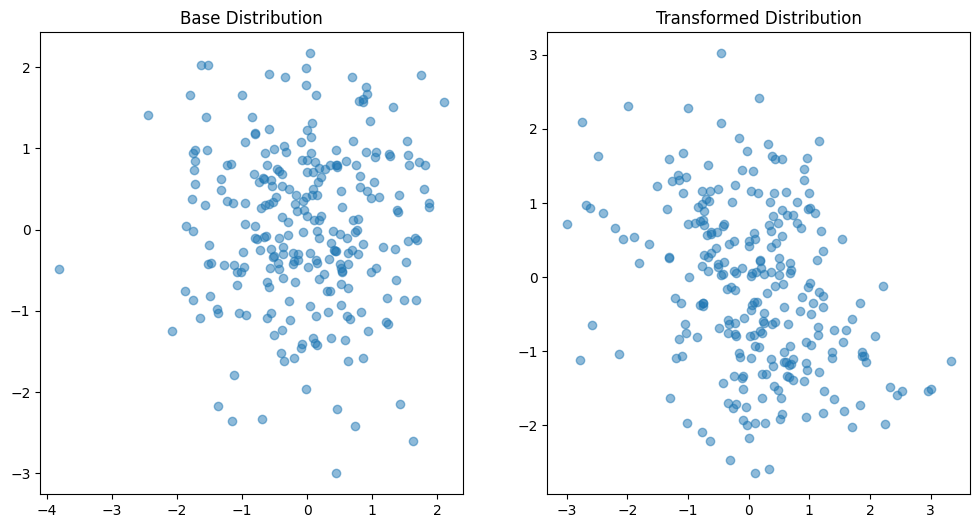

Epoch 750, Loss: 2.866802930831909


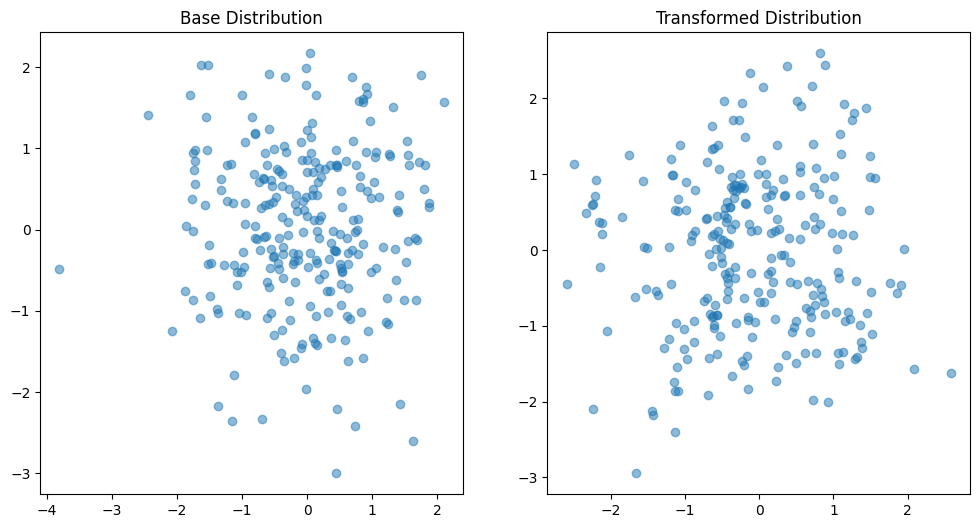

Epoch 1000, Loss: 2.911010980606079


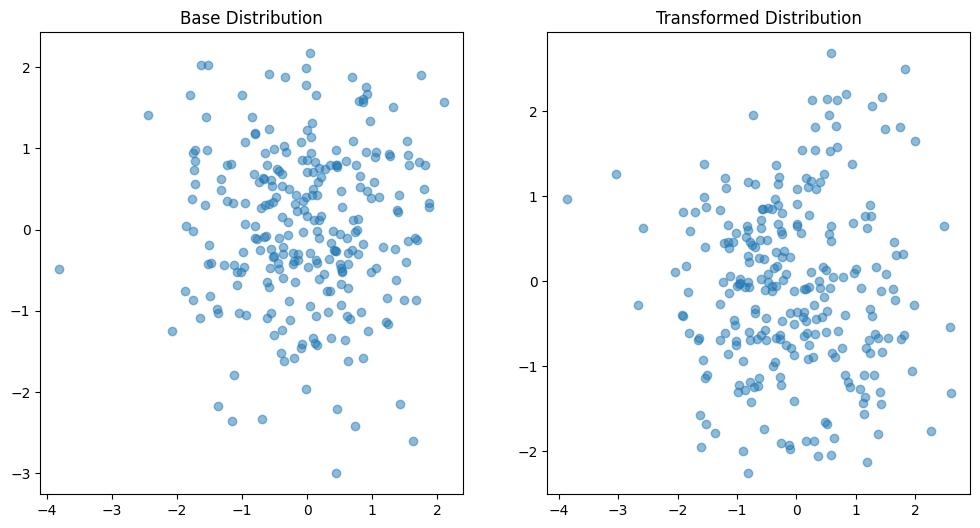

Epoch 1250, Loss: 2.8329358100891113


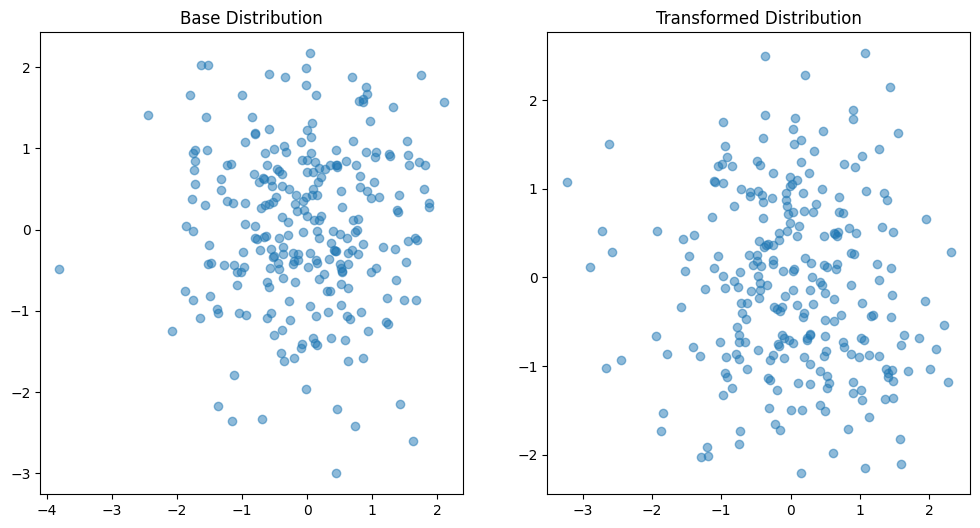

Epoch 1500, Loss: 2.791430950164795


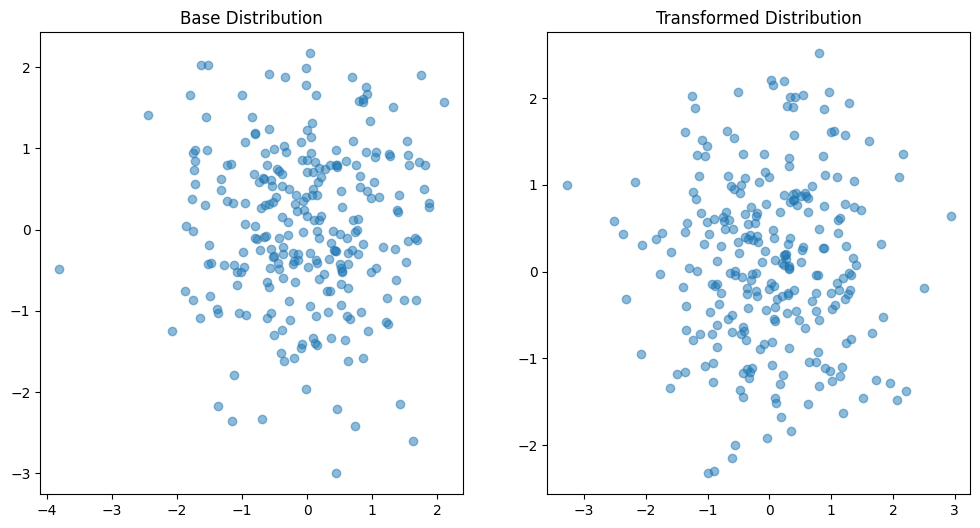

Epoch 1750, Loss: 2.860103130340576


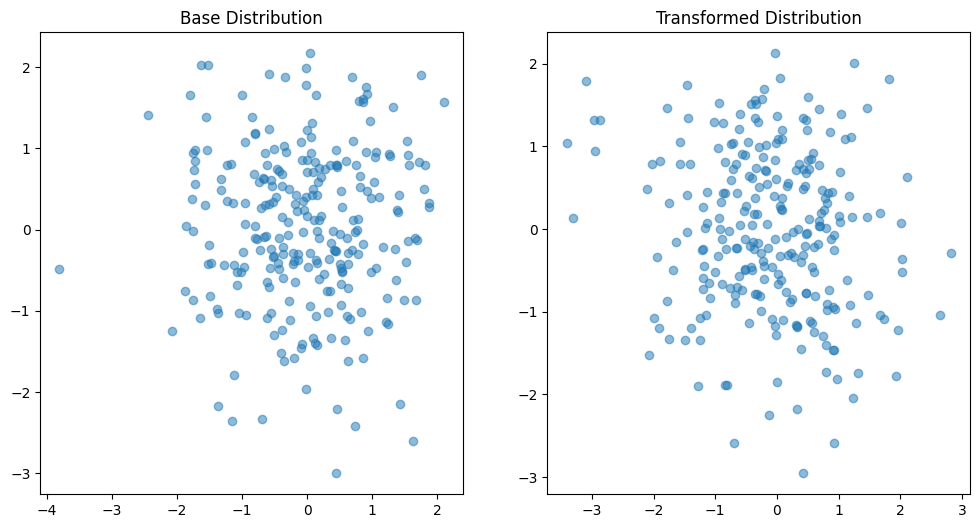

Epoch 2000, Loss: 2.8519742488861084


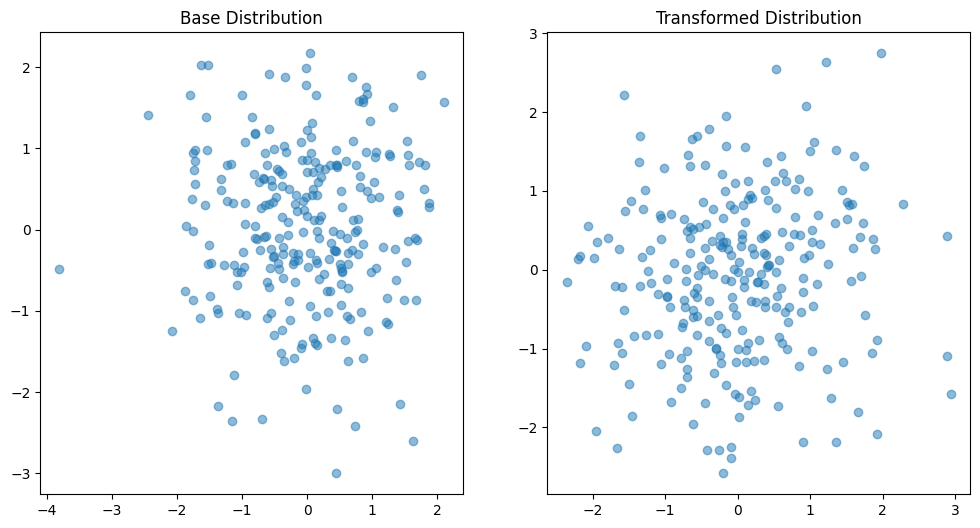

Epoch 2250, Loss: 2.856067657470703


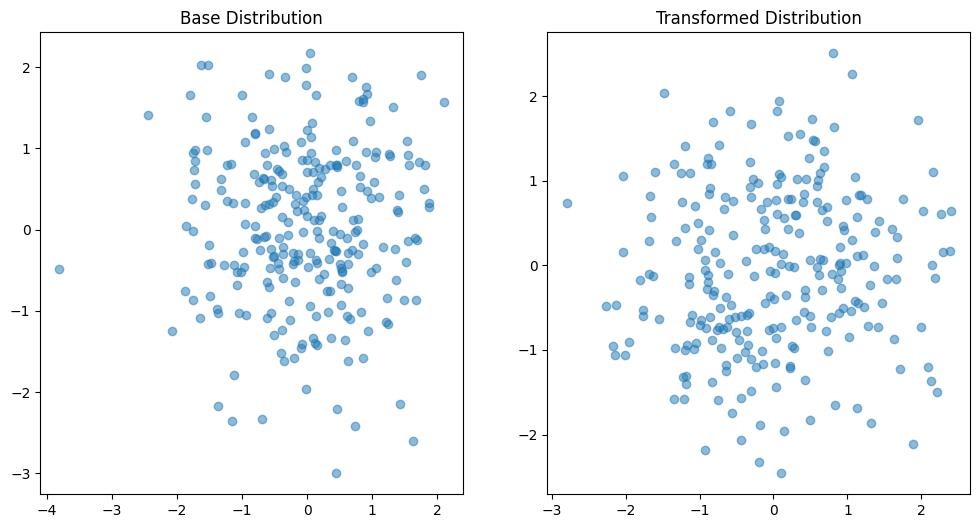

Epoch 2500, Loss: 2.819899559020996


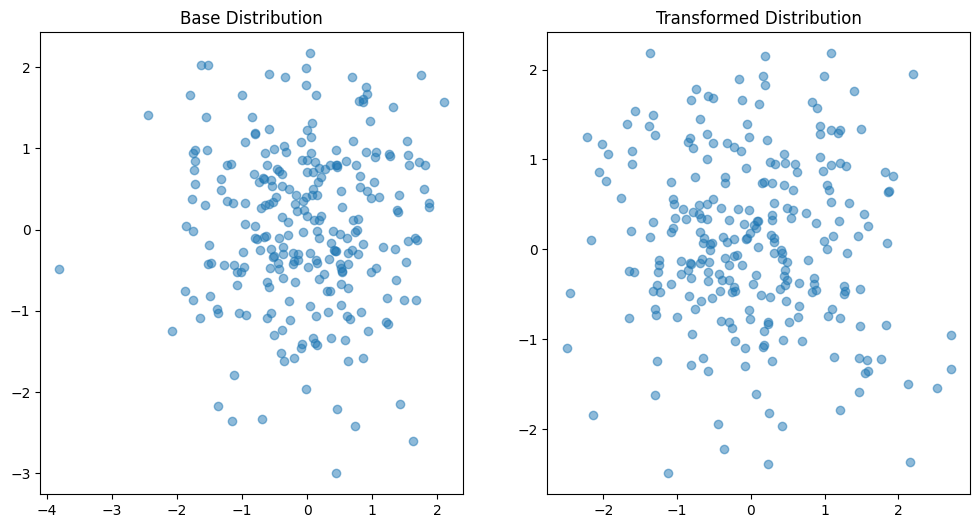

Epoch 2750, Loss: 2.7953834533691406


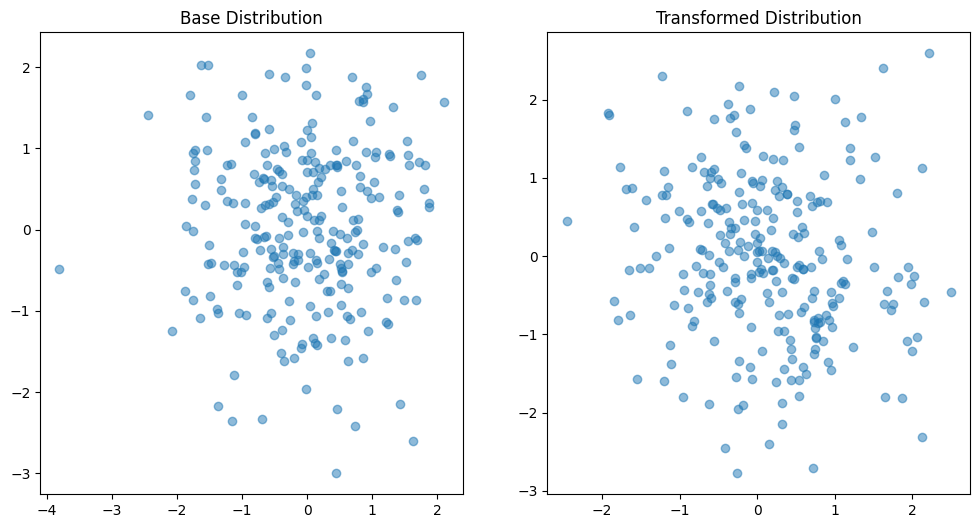

Epoch 3000, Loss: 2.8068394660949707


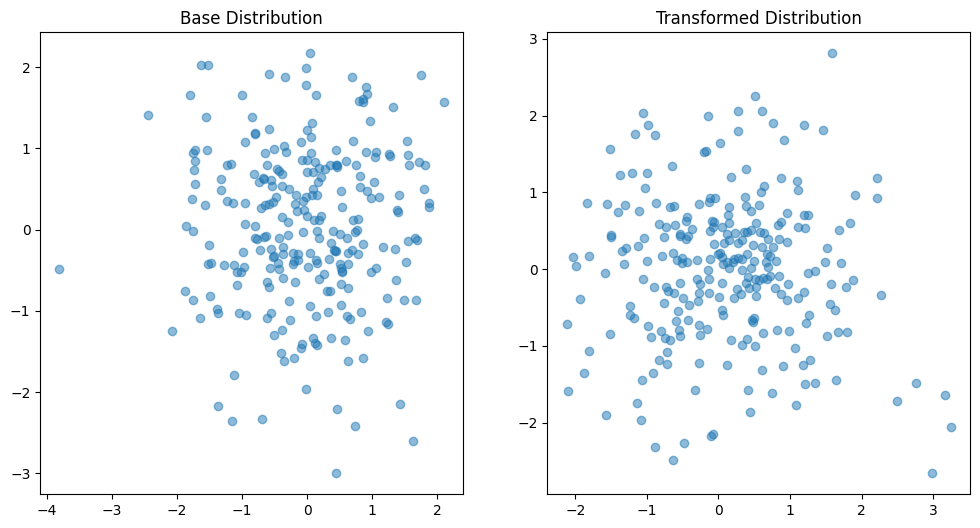

Epoch 3250, Loss: 2.760000228881836


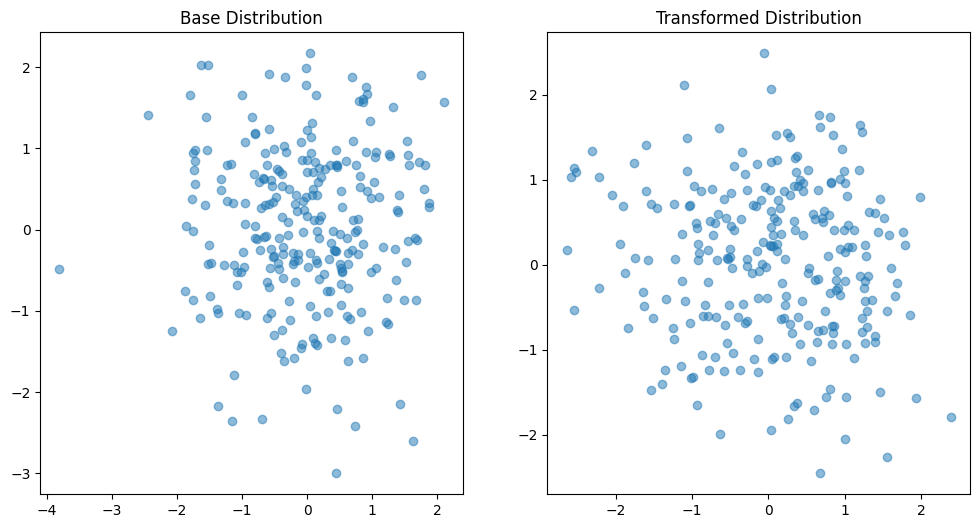

Epoch 3500, Loss: 2.8658840656280518


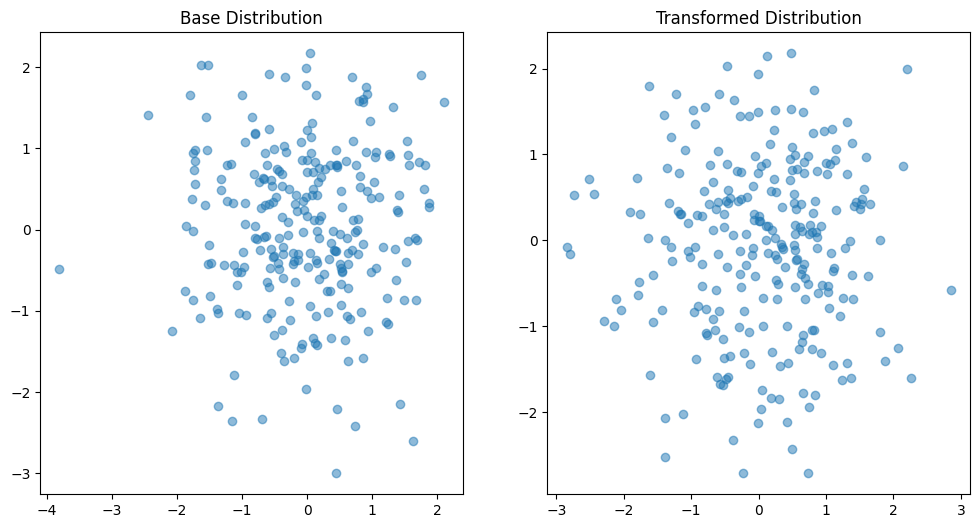

Epoch 3750, Loss: 2.759371757507324


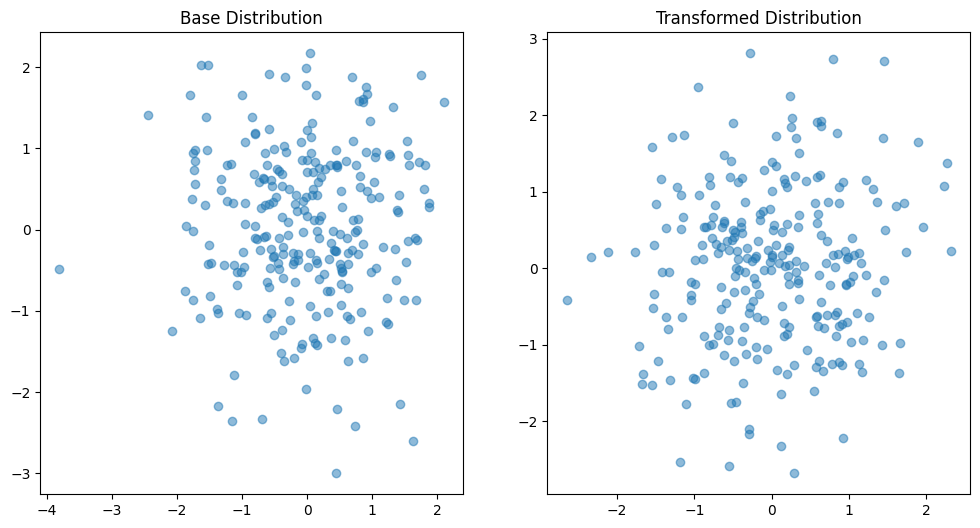

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.u = nn.Parameter(torch.randn(dim))
        self.w = nn.Parameter(torch.randn(dim))
        self.b = nn.Parameter(torch.randn(1))

    def forward(self, z):
        linear_term = torch.matmul(z, self.w) + self.b
        activation = torch.tanh(linear_term)
        return z + self.u * activation.unsqueeze(1)

    def log_det_jacobian(self, z):
        linear_term = torch.matmul(z, self.w) + self.b
        psi = (1 - torch.tanh(linear_term) ** 2).unsqueeze(1) * self.w.unsqueeze(0)
        det_jacobian = 1 + torch.matmul(psi, self.u.unsqueeze(1)).squeeze()
        return torch.log(torch.abs(det_jacobian))

    def inverse(self, z, num_iterations=10):
        # Initialize z_inv to z
        z_inv = z
        for _ in range(num_iterations):
            linear_term = torch.matmul(z_inv, self.w) + self.b
            activation = torch.tanh(linear_term)
            z_inv = z - self.u * activation.unsqueeze(1)
        return z_inv

class NormalizingFlow(nn.Module):
    def __init__(self, dim, num_flows):
        super(NormalizingFlow, self).__init__()
        self.flows = nn.ModuleList([PlanarFlow(dim) for _ in range(num_flows)])

    def forward(self, z):
        log_det_jacobians = []
        for flow in self.flows:
            z = flow(z)
            log_det_jacobians.append(flow.log_det_jacobian(z))
        return z, sum(log_det_jacobians)

    def inverse(self, z):
        for flow in reversed(self.flows):
            z = flow.inverse(z)
        return z

class FlowModel(nn.Module):
    def __init__(self, dim, num_flows):
        super(FlowModel, self).__init__()
        self.dim = dim
        self.base_dist = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
        self.flow = NormalizingFlow(dim, num_flows)

    def forward(self, num_samples):
        z0 = self.base_dist.sample((num_samples,))
        zk, log_det_jacobian = self.flow(z0)
        return zk, log_det_jacobian

    def log_prob(self, x):
        zk, log_det_jacobian = self.forward(x.size(0))
        base_log_prob = self.base_dist.log_prob(zk)
        return base_log_prob + log_det_jacobian

    def sample(self, num_samples):
        z0 = self.base_dist.sample((num_samples,))
        x = self.flow.inverse(z0)
        return x

# Hyperparams
dim = 2  # Dimension
num_flows = 5  # Number of flows
num_samples = 256  # Number of samples in a batch
num_epochs = 4000  # Number of epochs

#inicializacija
model = FlowModel(dim, num_flows)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

# Training
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 1. vizualizacija
z0 = model.base_dist.sample((num_samples,))
zk, _ = model.forward(num_samples)
ax[0].scatter(z0[:, 0].detach().numpy(), z0[:, 1].detach().numpy(), alpha=0.5)
ax[0].set_title('Base Distribution')

ax[1].scatter(zk[:, 0].detach().numpy(), zk[:, 1].detach().numpy(), alpha=0.5, color='red')
ax[1].set_title('Transformed Distribution')

for epoch in range(num_epochs):
    optimizer.zero_grad()
    zk, log_det_jacobian = model.forward(num_samples)
    base_log_prob = model.base_dist.log_prob(zk)
    loss = -torch.mean(base_log_prob + log_det_jacobian)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 250 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        ax[0].cla()
        ax[0].scatter(z0[:, 0].detach().numpy(), z0[:, 1].detach().numpy(), alpha=0.5)
        ax[0].set_title('Base Distribution')

        ax[1].cla()
        ax[1].scatter(zk[:, 0].detach().numpy(), zk[:, 1].detach().numpy(), alpha=0.5)
        ax[1].set_title('Transformed Distribution')
        plt.show()



Generiranje podatkov na podlagi modela

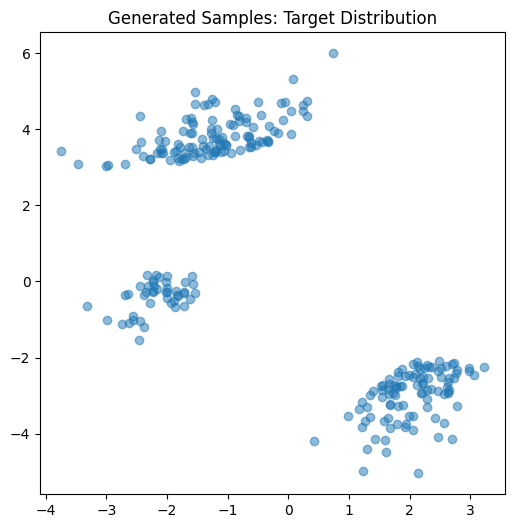

In [ ]:
# Gen podatki
num_generated_samples = 256
z0 = model.base_dist.sample((num_generated_samples,))
generated_samples = model.sample(num_generated_samples).detach().numpy()

# Visualizacija naučenega
plt.figure(figsize=(6, 6))
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5)
plt.title('Generated Samples: Target Distribution')
plt.show()
